## Import libraries 

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from feature_engine.creation import CyclicalFeatures
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

## Prepare the dataset

In [6]:
url = 'https://opendata.muenchen.de/dataset/5e73a82b-7cfb-40cc-9b30-45fe5a3fa24e/resource/40094bd6-f82d-4979-949b-26c8dc00b9a7/download/220511_monatszahlenmonatszahlen2204_verkehrsunfaelle.csv'
# work with only 2020 and earlier data as the challenge rules suggest
df = pd.read_csv(url)
df = df[df.JAHR<2022].fillna(method="ffill",axis='columns')
df = df[df.MONAT!='Summe'].reset_index()
df['MONAT_INT'] = df['MONAT'].astype(int)

In [21]:
train_df = df[(df.JAHR<2021) & (df.MONATSZAHL=='Alkoholunfälle') & (df.AUSPRAEGUNG=='insgesamt') & (df.MONAT!='Summe')]
test_df = df[(df.JAHR==2021) & (df.MONATSZAHL=='Alkoholunfälle') & (df.AUSPRAEGUNG=='insgesamt') & (df.MONAT!='Summe')]

features_list = ['JAHR','MONAT_INT','VORJAHRESWERT','VERAEND_VORMONAT_PROZENT','VERAEND_VORJAHRESMONAT_PROZENT','ZWOELF_MONATE_MITTELWERT']
X_train, X_val, y_train, y_val = train_test_split(train_df[features_list].values, train_df['WERT'].to_list(), test_size=0.2, random_state=42, shuffle=True)
X_test, y_test = test_df[features_list].values, test_df['WERT'].to_list()

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(201, 6)
(51, 6)
(12, 6)


## Define a prediction pipeline function

In [8]:
def prediction_pipeline(model, X_train, y_train, X_val, y_val, X_test, y_test):
    subsets = {'train':{'X':X_train,'y':y_train}, 'val':{'X':X_val,'y':y_val}, 'test':{'X':X_test,'y':y_test}}
    fig, axs = plt.subplots(3, 1, figsize=(15,15))
    for idx, subset in enumerate(subsets.keys()):
        pred = model.predict(subsets[subset]['X'])
        loss = round(mse(subsets[subset]['y'], pred, squared=False), 3)
        axs[idx].plot(subsets[subset]['y'], label='y_'+subset)
        axs[idx].plot(pred, label='pred_'+subset)
        axs[idx].legend(loc='upper right')
        axs[idx].annotate(subset+' MSE: '+str(loss), xy=(0.87, 0.1), xycoords="axes fraction", bbox=dict(boxstyle="round", fc="w", alpha=0.5))
        axs[idx].set_title('Mean squared error of the '+subset+' dataset', fontsize=16)
    plt.show()

## Build a Liner Regression model

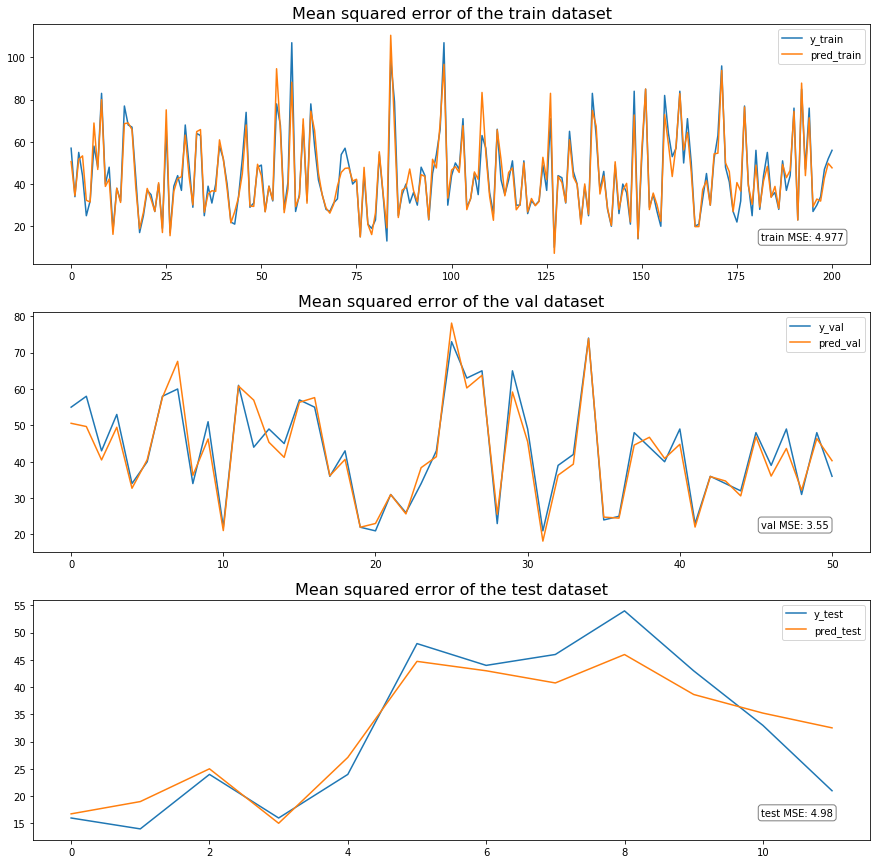

In [65]:
from sklearn.linear_model import LinearRegression, Ridge

lr = Ridge(alpha=0.001)
lr.fit(X_train, y_train)
prediction_pipeline(lr, X_train, y_train, X_val, y_val, X_test, y_test)

## Build a Random Forest model with Grid Search hyperparameter optimization

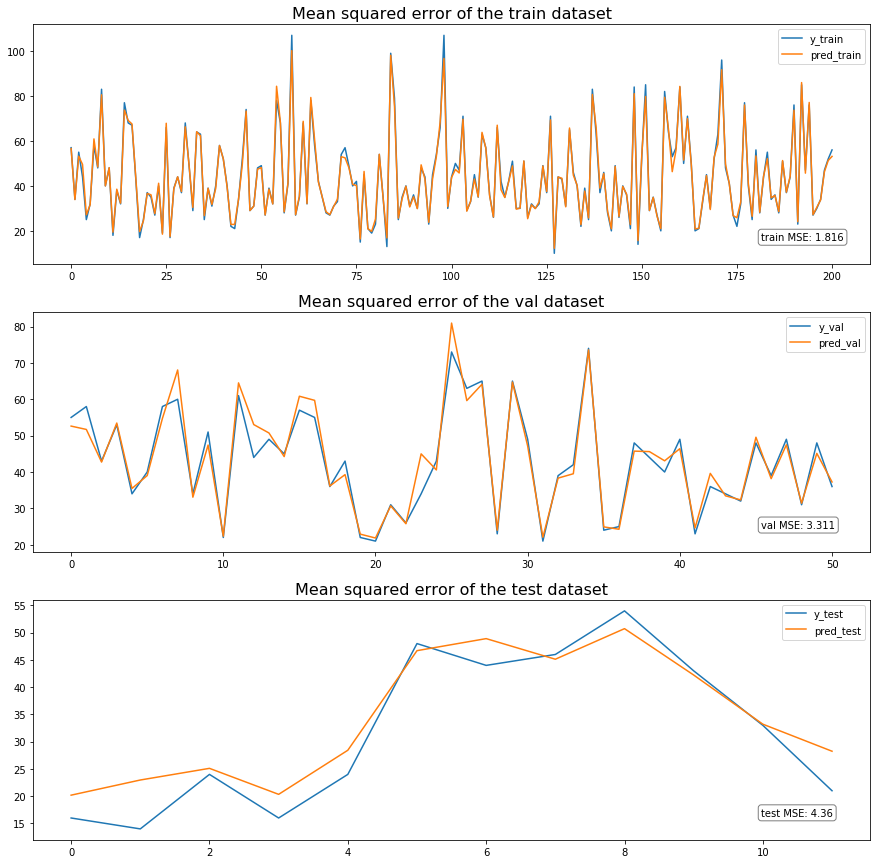

In [66]:
rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=42)
rf.fit(X_train, y_train)
prediction_pipeline(rf, X_train, y_train, X_val, y_val, X_test, y_test)

# Build a CatBoost model with automated Bayesian hyperparameter optimization

In [9]:
from catboost import CatBoostRegressor, Pool
import optuna
from optuna.samplers import TPESampler

In [10]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 100),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])
    }
    cb = CatBoostRegressor(**params, random_seed=42)
    cb.fit(X_train, y_train, eval_set=(X_val, y_val))
    pred_val = cb.predict(X_val).reshape(-1, 1)
    val_rmse = mse(y_val, pred_val, squared=False)
    return val_rmse

In [11]:
sampler = TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=20)

[I 2022-11-21 20:29:08,518] A new study created in memory with name: no-name-6d4822ae-ef56-4d46-9277-b4e511641972


0:	learn: 18.4625111	test: 13.4303963	best: 13.4303963 (0)	total: 143ms	remaining: 2m 22s
1:	learn: 18.1528528	test: 13.2114465	best: 13.2114465 (1)	total: 207ms	remaining: 1m 43s
2:	learn: 17.7802078	test: 12.8682633	best: 12.8682633 (2)	total: 233ms	remaining: 1m 17s
3:	learn: 17.1384920	test: 12.4359428	best: 12.4359428 (3)	total: 250ms	remaining: 1m 2s
4:	learn: 16.7687882	test: 12.1968518	best: 12.1968518 (4)	total: 298ms	remaining: 59.3s
5:	learn: 16.4175878	test: 11.8605220	best: 11.8605220 (5)	total: 331ms	remaining: 54.8s
6:	learn: 16.1330953	test: 11.6607263	best: 11.6607263 (6)	total: 377ms	remaining: 53.5s
7:	learn: 15.8345749	test: 11.4373007	best: 11.4373007 (7)	total: 420ms	remaining: 52.1s
8:	learn: 15.5694033	test: 11.2367949	best: 11.2367949 (8)	total: 458ms	remaining: 50.4s
9:	learn: 15.2677863	test: 11.0046183	best: 11.0046183 (9)	total: 506ms	remaining: 50.1s
10:	learn: 15.0497886	test: 10.8461244	best: 10.8461244 (10)	total: 536ms	remaining: 48.2s
11:	learn: 14.40

[I 2022-11-21 20:30:10,880] Trial 0 finished with value: 3.574368301841147 and parameters: {'learning_rate': 0.19352465823520762, 'depth': 10, 'l2_leaf_reg': 73.46740023932911, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 3.574368301841147.


0:	learn: 18.7669391	test: 13.6964132	best: 13.6964132 (0)	total: 11.8ms	remaining: 11.8s
1:	learn: 18.5992676	test: 13.5917854	best: 13.5917854 (1)	total: 23.3ms	remaining: 11.6s
2:	learn: 18.4531498	test: 13.4671136	best: 13.4671136 (2)	total: 35.4ms	remaining: 11.8s
3:	learn: 18.2471738	test: 13.3131027	best: 13.3131027 (3)	total: 47ms	remaining: 11.7s
4:	learn: 18.1131792	test: 13.2173968	best: 13.2173968 (4)	total: 56.9ms	remaining: 11.3s
5:	learn: 17.9632306	test: 13.0723277	best: 13.0723277 (5)	total: 69.3ms	remaining: 11.5s
6:	learn: 17.8412117	test: 12.9795299	best: 12.9795299 (6)	total: 81.5ms	remaining: 11.6s
7:	learn: 17.7033720	test: 12.8677777	best: 12.8677777 (7)	total: 92.7ms	remaining: 11.5s
8:	learn: 17.5356418	test: 12.7419516	best: 12.7419516 (8)	total: 104ms	remaining: 11.4s
9:	learn: 17.3894288	test: 12.6565768	best: 12.6565768 (9)	total: 117ms	remaining: 11.6s
10:	learn: 17.2300894	test: 12.5181485	best: 12.5181485 (10)	total: 128ms	remaining: 11.5s
11:	learn: 17

[I 2022-11-21 20:30:32,856] Trial 1 finished with value: 2.4873791217879058 and parameters: {'learning_rate': 0.03846096996241773, 'depth': 9, 'l2_leaf_reg': 60.510386162577674, 'grow_policy': 'Lossguide'}. Best is trial 1 with value: 2.4873791217879058.


0:	learn: 15.6754951	test: 11.3844623	best: 11.3844623 (0)	total: 6.58ms	remaining: 6.58s
1:	learn: 13.3964101	test: 9.7411048	best: 9.7411048 (1)	total: 12.9ms	remaining: 6.43s
2:	learn: 11.5673458	test: 8.2633449	best: 8.2633449 (2)	total: 17.9ms	remaining: 5.94s
3:	learn: 9.9342641	test: 7.3137266	best: 7.3137266 (3)	total: 22.1ms	remaining: 5.5s
4:	learn: 8.8275384	test: 6.7262950	best: 6.7262950 (4)	total: 27.3ms	remaining: 5.43s
5:	learn: 7.9891076	test: 6.2585008	best: 6.2585008 (5)	total: 32.2ms	remaining: 5.34s
6:	learn: 7.1490362	test: 6.0274650	best: 6.0274650 (6)	total: 37.3ms	remaining: 5.29s
7:	learn: 6.5683451	test: 5.6845491	best: 5.6845491 (7)	total: 42ms	remaining: 5.21s
8:	learn: 6.0961840	test: 5.5966126	best: 5.5966126 (8)	total: 46.9ms	remaining: 5.16s
9:	learn: 5.6996056	test: 5.3302071	best: 5.3302071 (9)	total: 51.8ms	remaining: 5.13s
10:	learn: 5.3412015	test: 5.1784752	best: 5.1784752 (10)	total: 56.8ms	remaining: 5.11s
11:	learn: 5.0897170	test: 5.1107764	be

[I 2022-11-21 20:30:42,549] Trial 2 finished with value: 3.2783960656584865 and parameters: {'learning_rate': 0.41789689399220664, 'depth': 4, 'l2_leaf_reg': 19.00067175350296, 'grow_policy': 'Lossguide'}. Best is trial 1 with value: 2.4873791217879058.


0:	learn: 18.1536083	test: 13.2407696	best: 13.2407696 (0)	total: 9.36ms	remaining: 9.35s
1:	learn: 17.5515572	test: 12.7427218	best: 12.7427218 (1)	total: 18.6ms	remaining: 9.26s
2:	learn: 16.7054979	test: 12.0688688	best: 12.0688688 (2)	total: 27.4ms	remaining: 9.1s
3:	learn: 16.1090198	test: 11.6786421	best: 11.6786421 (3)	total: 35.3ms	remaining: 8.79s
4:	learn: 15.5693176	test: 11.2835836	best: 11.2835836 (4)	total: 42.3ms	remaining: 8.43s
5:	learn: 14.9194643	test: 10.7647131	best: 10.7647131 (5)	total: 49.2ms	remaining: 8.15s
6:	learn: 14.0387224	test: 10.0786621	best: 10.0786621 (6)	total: 57.1ms	remaining: 8.1s
7:	learn: 13.6404633	test: 9.8097345	best: 9.8097345 (7)	total: 64.9ms	remaining: 8.04s
8:	learn: 13.1665622	test: 9.5319094	best: 9.5319094 (8)	total: 73.9ms	remaining: 8.14s
9:	learn: 12.7604273	test: 9.2183684	best: 9.2183684 (9)	total: 83.2ms	remaining: 8.23s
10:	learn: 12.1655965	test: 8.9135246	best: 8.9135246 (10)	total: 90.1ms	remaining: 8.1s
11:	learn: 11.75533

[I 2022-11-21 20:31:10,227] Trial 3 finished with value: 2.3148719707775625 and parameters: {'learning_rate': 0.22165305913463673, 'depth': 5, 'l2_leaf_reg': 61.573436577515565, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 2.3148719707775625.


0:	learn: 17.6127680	test: 12.8047206	best: 12.8047206 (0)	total: 141ms	remaining: 2m 20s
1:	learn: 16.6569023	test: 12.0585152	best: 12.0585152 (1)	total: 275ms	remaining: 2m 17s
2:	learn: 15.4603227	test: 11.4180069	best: 11.4180069 (2)	total: 414ms	remaining: 2m 17s
3:	learn: 14.6073249	test: 10.9492091	best: 10.9492091 (3)	total: 509ms	remaining: 2m 6s
4:	learn: 13.7108937	test: 10.1506125	best: 10.1506125 (4)	total: 647ms	remaining: 2m 8s
5:	learn: 12.8537012	test: 9.5552091	best: 9.5552091 (5)	total: 723ms	remaining: 1m 59s
6:	learn: 12.1917030	test: 9.1313637	best: 9.1313637 (6)	total: 804ms	remaining: 1m 54s
7:	learn: 11.1461851	test: 8.3781304	best: 8.3781304 (7)	total: 842ms	remaining: 1m 44s
8:	learn: 10.7538236	test: 8.1948860	best: 8.1948860 (8)	total: 935ms	remaining: 1m 42s
9:	learn: 10.2883264	test: 7.8511881	best: 7.8511881 (9)	total: 976ms	remaining: 1m 36s
10:	learn: 9.7756780	test: 7.5861985	best: 7.5861985 (10)	total: 1.01s	remaining: 1m 30s
11:	learn: 9.4038641	te

[I 2022-11-21 20:32:23,817] Trial 4 finished with value: 2.853216796412992 and parameters: {'learning_rate': 0.2334742922663476, 'depth': 9, 'l2_leaf_reg': 20.767704433677615, 'grow_policy': 'Depthwise'}. Best is trial 3 with value: 2.3148719707775625.


0:	learn: 15.9100876	test: 11.8614006	best: 11.8614006 (0)	total: 4.5ms	remaining: 4.49s
1:	learn: 13.7053838	test: 10.7659478	best: 10.7659478 (1)	total: 9.33ms	remaining: 4.65s
2:	learn: 11.8645667	test: 9.3359600	best: 9.3359600 (2)	total: 14.1ms	remaining: 4.68s
3:	learn: 10.6099219	test: 8.3661668	best: 8.3661668 (3)	total: 18.4ms	remaining: 4.58s
4:	learn: 9.4372891	test: 7.7612518	best: 7.7612518 (4)	total: 22.9ms	remaining: 4.55s
5:	learn: 8.4608602	test: 7.1897472	best: 7.1897472 (5)	total: 29.1ms	remaining: 4.83s
6:	learn: 7.5310101	test: 6.4679699	best: 6.4679699 (6)	total: 34.8ms	remaining: 4.94s
7:	learn: 6.9355213	test: 6.2550925	best: 6.2550925 (7)	total: 39.1ms	remaining: 4.85s
8:	learn: 6.4022981	test: 6.0702475	best: 6.0702475 (8)	total: 43.9ms	remaining: 4.83s
9:	learn: 5.8483693	test: 5.7041743	best: 5.7041743 (9)	total: 48.7ms	remaining: 4.82s
10:	learn: 5.3853562	test: 5.2939420	best: 5.2939420 (10)	total: 54ms	remaining: 4.86s
11:	learn: 4.9580810	test: 5.0454408

[I 2022-11-21 20:32:29,804] Trial 5 finished with value: 2.9444988917669153 and parameters: {'learning_rate': 0.3076969774317048, 'depth': 4, 'l2_leaf_reg': 7.4401077055426725, 'grow_policy': 'Depthwise'}. Best is trial 3 with value: 2.3148719707775625.


0:	learn: 18.2389117	test: 13.3051398	best: 13.3051398 (0)	total: 3.58ms	remaining: 3.58s
1:	learn: 17.5746991	test: 12.8057930	best: 12.8057930 (1)	total: 8.24ms	remaining: 4.11s
2:	learn: 17.0347221	test: 12.4078487	best: 12.4078487 (2)	total: 11.6ms	remaining: 3.86s
3:	learn: 16.4934493	test: 11.9698024	best: 11.9698024 (3)	total: 15.8ms	remaining: 3.94s
4:	learn: 15.8207396	test: 11.4390646	best: 11.4390646 (4)	total: 19.6ms	remaining: 3.91s
5:	learn: 15.1675178	test: 10.9777922	best: 10.9777922 (5)	total: 22.1ms	remaining: 3.66s
6:	learn: 14.7060782	test: 10.6126250	best: 10.6126250 (6)	total: 25.6ms	remaining: 3.63s
7:	learn: 14.2192395	test: 10.2214717	best: 10.2214717 (7)	total: 28.6ms	remaining: 3.55s
8:	learn: 13.8226809	test: 9.8415830	best: 9.8415830 (8)	total: 31.5ms	remaining: 3.47s
9:	learn: 13.3986310	test: 9.5381008	best: 9.5381008 (9)	total: 34.6ms	remaining: 3.43s
10:	learn: 12.8599013	test: 9.1995402	best: 9.1995402 (10)	total: 37.5ms	remaining: 3.37s
11:	learn: 12.

[I 2022-11-21 20:32:34,093] Trial 6 finished with value: 3.092463156051987 and parameters: {'learning_rate': 0.15926074689495165, 'depth': 3, 'l2_leaf_reg': 68.73906962470353, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 2.3148719707775625.


993:	learn: 1.0239142	test: 3.0945876	best: 3.0935319 (971)	total: 3.4s	remaining: 20.5ms
994:	learn: 1.0235824	test: 3.0942113	best: 3.0935319 (971)	total: 3.4s	remaining: 17.1ms
995:	learn: 1.0225153	test: 3.0926021	best: 3.0926021 (995)	total: 3.41s	remaining: 13.7ms
996:	learn: 1.0216745	test: 3.0927073	best: 3.0926021 (995)	total: 3.41s	remaining: 10.3ms
997:	learn: 1.0211743	test: 3.0937690	best: 3.0926021 (995)	total: 3.42s	remaining: 6.85ms
998:	learn: 1.0196281	test: 3.0924632	best: 3.0924632 (998)	total: 3.42s	remaining: 3.43ms
999:	learn: 1.0191470	test: 3.0927922	best: 3.0924632 (998)	total: 3.43s	remaining: 0us

bestTest = 3.092463156
bestIteration = 998

Shrink model to first 999 iterations.
0:	learn: 18.8193557	test: 13.7359081	best: 13.7359081 (0)	total: 27.4ms	remaining: 27.4s
1:	learn: 18.7222548	test: 13.6563553	best: 13.6563553 (1)	total: 57.8ms	remaining: 28.8s
2:	learn: 18.6315159	test: 13.5945317	best: 13.5945317 (2)	total: 88.2ms	remaining: 29.3s
3:	learn: 18.51

[I 2022-11-21 20:33:18,830] Trial 7 finished with value: 3.966097762226914 and parameters: {'learning_rate': 0.02685037534645701, 'depth': 10, 'l2_leaf_reg': 26.619218178401674, 'grow_policy': 'SymmetricTree'}. Best is trial 3 with value: 2.3148719707775625.


0:	learn: 18.1726564	test: 13.2484774	best: 13.2484774 (0)	total: 71.8ms	remaining: 1m 11s
1:	learn: 17.3762248	test: 12.7562672	best: 12.7562672 (1)	total: 81.9ms	remaining: 40.9s
2:	learn: 16.6578419	test: 12.2619895	best: 12.2619895 (2)	total: 106ms	remaining: 35.2s
3:	learn: 15.8852881	test: 11.6819091	best: 11.6819091 (3)	total: 114ms	remaining: 28.5s
4:	learn: 15.2273535	test: 11.1408606	best: 11.1408606 (4)	total: 125ms	remaining: 24.8s
5:	learn: 14.7594215	test: 10.8005343	best: 10.8005343 (5)	total: 150ms	remaining: 24.8s
6:	learn: 14.2510443	test: 10.3595539	best: 10.3595539 (6)	total: 157ms	remaining: 22.3s
7:	learn: 13.8554261	test: 10.1246414	best: 10.1246414 (7)	total: 165ms	remaining: 20.5s
8:	learn: 13.3839294	test: 9.7856552	best: 9.7856552 (8)	total: 177ms	remaining: 19.5s
9:	learn: 12.8985866	test: 9.4877526	best: 9.4877526 (9)	total: 189ms	remaining: 18.7s
10:	learn: 12.5309091	test: 9.3033509	best: 9.3033509 (10)	total: 195ms	remaining: 17.5s
11:	learn: 12.1088501	

[I 2022-11-21 20:33:25,385] Trial 8 finished with value: 2.7343570148981304 and parameters: {'learning_rate': 0.277888036878207, 'depth': 4, 'l2_leaf_reg': 96.9888781486913, 'grow_policy': 'Depthwise'}. Best is trial 3 with value: 2.3148719707775625.


990:	learn: 0.4205573	test: 2.7376826	best: 2.7366433 (938)	total: 5.47s	remaining: 49.7ms
991:	learn: 0.4200985	test: 2.7377447	best: 2.7366433 (938)	total: 5.47s	remaining: 44.1ms
992:	learn: 0.4185771	test: 2.7372572	best: 2.7366433 (938)	total: 5.48s	remaining: 38.6ms
993:	learn: 0.4174908	test: 2.7365124	best: 2.7365124 (993)	total: 5.48s	remaining: 33.1ms
994:	learn: 0.4173333	test: 2.7365574	best: 2.7365124 (993)	total: 5.49s	remaining: 27.6ms
995:	learn: 0.4162212	test: 2.7356859	best: 2.7356859 (995)	total: 5.49s	remaining: 22.1ms
996:	learn: 0.4157184	test: 2.7353957	best: 2.7353957 (996)	total: 5.5s	remaining: 16.5ms
997:	learn: 0.4146644	test: 2.7348876	best: 2.7348876 (997)	total: 5.5s	remaining: 11ms
998:	learn: 0.4141681	test: 2.7343570	best: 2.7343570 (998)	total: 5.51s	remaining: 5.51ms
999:	learn: 0.4134914	test: 2.7344425	best: 2.7343570 (998)	total: 5.51s	remaining: 0us

bestTest = 2.734357015
bestIteration = 998

Shrink model to first 999 iterations.
0:	learn: 16.0

[I 2022-11-21 20:33:50,738] Trial 9 finished with value: 2.8359388115188326 and parameters: {'learning_rate': 0.30297098961743174, 'depth': 10, 'l2_leaf_reg': 9.76075770314003, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 2.3148719707775625.


0:	learn: 16.3731984	test: 12.0943523	best: 12.0943523 (0)	total: 18.3ms	remaining: 18.3s
1:	learn: 14.4162476	test: 10.6250583	best: 10.6250583 (1)	total: 29.9ms	remaining: 14.9s
2:	learn: 12.6685585	test: 9.5871535	best: 9.5871535 (2)	total: 41.8ms	remaining: 13.9s
3:	learn: 11.6790005	test: 8.8308141	best: 8.8308141 (3)	total: 53.9ms	remaining: 13.4s
4:	learn: 10.3963177	test: 8.0270660	best: 8.0270660 (4)	total: 91.7ms	remaining: 18.2s
5:	learn: 9.6205003	test: 7.4247102	best: 7.4247102 (5)	total: 115ms	remaining: 19.1s
6:	learn: 8.9202976	test: 6.8207784	best: 6.8207784 (6)	total: 132ms	remaining: 18.7s
7:	learn: 8.2281458	test: 6.4458647	best: 6.4458647 (7)	total: 152ms	remaining: 18.9s
8:	learn: 7.6692977	test: 6.1855508	best: 6.1855508 (8)	total: 164ms	remaining: 18.1s
9:	learn: 7.2529332	test: 5.9571509	best: 5.9571509 (9)	total: 178ms	remaining: 17.6s
10:	learn: 6.8388638	test: 5.6643761	best: 5.6643761 (10)	total: 204ms	remaining: 18.4s
11:	learn: 6.4139365	test: 5.3736803	b

[I 2022-11-21 20:34:08,407] Trial 10 finished with value: 2.8858471728858683 and parameters: {'learning_rate': 0.4731169066728894, 'depth': 6, 'l2_leaf_reg': 43.56774265198179, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 2.3148719707775625.


0:	learn: 18.8709855	test: 13.7781869	best: 13.7781869 (0)	total: 14.3ms	remaining: 14.2s
1:	learn: 18.7798190	test: 13.7074965	best: 13.7074965 (1)	total: 27ms	remaining: 13.5s
2:	learn: 18.6850408	test: 13.6164998	best: 13.6164998 (2)	total: 42.1ms	remaining: 14s
3:	learn: 18.6252393	test: 13.5674300	best: 13.5674300 (3)	total: 62.1ms	remaining: 15.5s
4:	learn: 18.5514250	test: 13.5164155	best: 13.5164155 (4)	total: 80.3ms	remaining: 16s
5:	learn: 18.4982865	test: 13.4761914	best: 13.4761914 (5)	total: 101ms	remaining: 16.8s
6:	learn: 18.4374425	test: 13.4389361	best: 13.4389361 (6)	total: 131ms	remaining: 18.6s
7:	learn: 18.3807638	test: 13.3896033	best: 13.3896033 (7)	total: 184ms	remaining: 22.9s
8:	learn: 18.3149547	test: 13.3328754	best: 13.3328754 (8)	total: 234ms	remaining: 25.7s
9:	learn: 18.2421488	test: 13.2662067	best: 13.2662067 (9)	total: 267ms	remaining: 26.4s
10:	learn: 18.1677378	test: 13.1965376	best: 13.1965376 (10)	total: 283ms	remaining: 25.5s
11:	learn: 18.100053

[I 2022-11-21 20:34:42,061] Trial 11 finished with value: 2.9635019424534947 and parameters: {'learning_rate': 0.01626643985051671, 'depth': 7, 'l2_leaf_reg': 55.179515280874924, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 2.3148719707775625.


0:	learn: 18.5521208	test: 13.5611997	best: 13.5611997 (0)	total: 16ms	remaining: 16s
1:	learn: 18.1615956	test: 13.2826346	best: 13.2826346 (1)	total: 28.5ms	remaining: 14.2s
2:	learn: 17.7126842	test: 12.8532800	best: 12.8532800 (2)	total: 42.7ms	remaining: 14.2s
3:	learn: 17.4314073	test: 12.5702562	best: 12.5702562 (3)	total: 62.8ms	remaining: 15.6s
4:	learn: 17.1716322	test: 12.3335226	best: 12.3335226 (4)	total: 82.3ms	remaining: 16.4s
5:	learn: 16.9556024	test: 12.1833452	best: 12.1833452 (5)	total: 93.8ms	remaining: 15.5s
6:	learn: 16.5998742	test: 11.9466892	best: 11.9466892 (6)	total: 107ms	remaining: 15.2s
7:	learn: 16.3287195	test: 11.7622656	best: 11.7622656 (7)	total: 122ms	remaining: 15.2s
8:	learn: 16.0868257	test: 11.5663981	best: 11.5663981 (8)	total: 135ms	remaining: 14.9s
9:	learn: 15.8130231	test: 11.3455762	best: 11.3455762 (9)	total: 149ms	remaining: 14.8s
10:	learn: 15.5992006	test: 11.1342553	best: 11.1342553 (10)	total: 165ms	remaining: 14.8s
11:	learn: 15.386

[I 2022-11-21 20:35:09,781] Trial 12 finished with value: 2.357473700435977 and parameters: {'learning_rate': 0.1008699517542499, 'depth': 7, 'l2_leaf_reg': 80.20789793742367, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 2.3148719707775625.


0:	learn: 18.5145092	test: 13.5253464	best: 13.5253464 (0)	total: 15.5ms	remaining: 15.5s
1:	learn: 18.1660258	test: 13.2731183	best: 13.2731183 (1)	total: 37.6ms	remaining: 18.8s
2:	learn: 17.7749570	test: 12.9909994	best: 12.9909994 (2)	total: 57ms	remaining: 18.9s
3:	learn: 17.4936921	test: 12.7268927	best: 12.7268927 (3)	total: 77.2ms	remaining: 19.2s
4:	learn: 17.0411530	test: 12.3589049	best: 12.3589049 (4)	total: 99.3ms	remaining: 19.8s
5:	learn: 16.7426132	test: 12.1288697	best: 12.1288697 (5)	total: 146ms	remaining: 24.2s
6:	learn: 16.4440735	test: 11.8915965	best: 11.8915965 (6)	total: 182ms	remaining: 25.8s
7:	learn: 16.2447438	test: 11.7562079	best: 11.7562079 (7)	total: 218ms	remaining: 27s
8:	learn: 15.8348189	test: 11.4513229	best: 11.4513229 (8)	total: 278ms	remaining: 30.6s
9:	learn: 15.4516789	test: 11.1036624	best: 11.1036624 (9)	total: 295ms	remaining: 29.3s
10:	learn: 15.2442208	test: 10.9602139	best: 10.9602139 (10)	total: 315ms	remaining: 28.3s
11:	learn: 14.9514

[I 2022-11-21 20:35:43,729] Trial 13 finished with value: 2.482224278890223 and parameters: {'learning_rate': 0.11938448268176423, 'depth': 6, 'l2_leaf_reg': 86.43108555792958, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 2.3148719707775625.


0:	learn: 18.4320341	test: 13.4815523	best: 13.4815523 (0)	total: 21ms	remaining: 21s
1:	learn: 17.8883403	test: 13.0761289	best: 13.0761289 (1)	total: 36.2ms	remaining: 18.1s
2:	learn: 17.3548554	test: 12.6388616	best: 12.6388616 (2)	total: 48.6ms	remaining: 16.1s
3:	learn: 16.7614646	test: 12.0561550	best: 12.0561550 (3)	total: 72.9ms	remaining: 18.2s
4:	learn: 16.5060239	test: 11.8617754	best: 11.8617754 (4)	total: 88.4ms	remaining: 17.6s
5:	learn: 16.0343552	test: 11.5497191	best: 11.5497191 (5)	total: 102ms	remaining: 16.9s
6:	learn: 15.7267488	test: 11.3114516	best: 11.3114516 (6)	total: 137ms	remaining: 19.4s
7:	learn: 15.3684823	test: 11.0635896	best: 11.0635896 (7)	total: 171ms	remaining: 21.2s
8:	learn: 14.9307628	test: 10.6933546	best: 10.6933546 (8)	total: 258ms	remaining: 28.4s
9:	learn: 14.5943913	test: 10.3990533	best: 10.3990533 (9)	total: 333ms	remaining: 33s
10:	learn: 14.3327667	test: 10.2253961	best: 10.2253961 (10)	total: 357ms	remaining: 32.1s
11:	learn: 14.123126

[I 2022-11-21 20:36:09,158] Trial 14 finished with value: 2.3831798834016653 and parameters: {'learning_rate': 0.08842638551586074, 'depth': 7, 'l2_leaf_reg': 40.71393147992628, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 2.3148719707775625.


0:	learn: 17.7355301	test: 12.8301003	best: 12.8301003 (0)	total: 8.73ms	remaining: 8.72s
1:	learn: 16.7945300	test: 12.1958383	best: 12.1958383 (1)	total: 12.4ms	remaining: 6.21s
2:	learn: 15.9075251	test: 11.5976762	best: 11.5976762 (2)	total: 16.1ms	remaining: 5.36s
3:	learn: 15.0956565	test: 11.0601742	best: 11.0601742 (3)	total: 19.8ms	remaining: 4.93s
4:	learn: 14.3674819	test: 10.5296650	best: 10.5296650 (4)	total: 23.6ms	remaining: 4.69s
5:	learn: 13.7292567	test: 10.0247091	best: 10.0247091 (5)	total: 26.8ms	remaining: 4.44s
6:	learn: 13.1040039	test: 9.7178268	best: 9.7178268 (6)	total: 30.1ms	remaining: 4.28s
7:	learn: 12.5205761	test: 9.3440809	best: 9.3440809 (7)	total: 33.7ms	remaining: 4.18s
8:	learn: 11.8821487	test: 8.8542272	best: 8.8542272 (8)	total: 38.5ms	remaining: 4.24s
9:	learn: 11.3850439	test: 8.4883819	best: 8.4883819 (9)	total: 41.6ms	remaining: 4.12s
10:	learn: 10.8941554	test: 8.1256350	best: 8.1256350 (10)	total: 44.7ms	remaining: 4.02s
11:	learn: 10.4584

[I 2022-11-21 20:36:14,829] Trial 15 finished with value: 2.56172295697612 and parameters: {'learning_rate': 0.34639603683417575, 'depth': 5, 'l2_leaf_reg': 78.91674684248571, 'grow_policy': 'SymmetricTree'}. Best is trial 3 with value: 2.3148719707775625.


987:	learn: 0.5889500	test: 2.5672360	best: 2.5670851 (986)	total: 4.53s	remaining: 55ms
988:	learn: 0.5886858	test: 2.5674973	best: 2.5670851 (986)	total: 4.54s	remaining: 50.5ms
989:	learn: 0.5875824	test: 2.5674345	best: 2.5670851 (986)	total: 4.54s	remaining: 45.9ms
990:	learn: 0.5867222	test: 2.5666221	best: 2.5666221 (990)	total: 4.54s	remaining: 41.3ms
991:	learn: 0.5858692	test: 2.5657949	best: 2.5657949 (991)	total: 4.55s	remaining: 36.7ms
992:	learn: 0.5853833	test: 2.5655962	best: 2.5655962 (992)	total: 4.55s	remaining: 32.1ms
993:	learn: 0.5851182	test: 2.5655598	best: 2.5655598 (993)	total: 4.56s	remaining: 27.5ms
994:	learn: 0.5835066	test: 2.5647454	best: 2.5647454 (994)	total: 4.56s	remaining: 22.9ms
995:	learn: 0.5824149	test: 2.5652029	best: 2.5647454 (994)	total: 4.56s	remaining: 18.3ms
996:	learn: 0.5820191	test: 2.5649319	best: 2.5647454 (994)	total: 4.57s	remaining: 13.7ms
997:	learn: 0.5818590	test: 2.5650774	best: 2.5647454 (994)	total: 4.57s	remaining: 9.16ms
9

[I 2022-11-21 20:36:38,342] Trial 16 finished with value: 2.2657016339519114 and parameters: {'learning_rate': 0.20688028647165813, 'depth': 8, 'l2_leaf_reg': 97.6090483625423, 'grow_policy': 'Lossguide'}. Best is trial 16 with value: 2.2657016339519114.


0:	learn: 18.2264950	test: 13.3106907	best: 13.3106907 (0)	total: 14.2ms	remaining: 14.2s
1:	learn: 17.5929960	test: 12.8783231	best: 12.8783231 (1)	total: 26.3ms	remaining: 13.1s
2:	learn: 17.0121093	test: 12.3557747	best: 12.3557747 (2)	total: 37.6ms	remaining: 12.5s
3:	learn: 16.5674520	test: 11.9810771	best: 11.9810771 (3)	total: 47.3ms	remaining: 11.8s
4:	learn: 16.2663056	test: 11.7540950	best: 11.7540950 (4)	total: 61.6ms	remaining: 12.2s
5:	learn: 15.8211700	test: 11.4631747	best: 11.4631747 (5)	total: 75.3ms	remaining: 12.5s
6:	learn: 15.1918664	test: 10.9266179	best: 10.9266179 (6)	total: 86.8ms	remaining: 12.3s
7:	learn: 14.8036658	test: 10.6426121	best: 10.6426121 (7)	total: 96.4ms	remaining: 12s
8:	learn: 14.2193092	test: 10.1804394	best: 10.1804394 (8)	total: 108ms	remaining: 11.9s
9:	learn: 13.7752317	test: 9.9574057	best: 9.9574057 (9)	total: 121ms	remaining: 12s
10:	learn: 13.2791710	test: 9.6289722	best: 9.6289722 (10)	total: 136ms	remaining: 12.2s
11:	learn: 12.94681

[I 2022-11-21 20:37:00,109] Trial 17 finished with value: 2.3467764667770536 and parameters: {'learning_rate': 0.2128951795485105, 'depth': 8, 'l2_leaf_reg': 99.9368814255136, 'grow_policy': 'Lossguide'}. Best is trial 16 with value: 2.2657016339519114.


0:	learn: 17.6062658	test: 12.7508778	best: 12.7508778 (0)	total: 3.31ms	remaining: 3.31s
1:	learn: 16.7559452	test: 12.1815918	best: 12.1815918 (1)	total: 8.62ms	remaining: 4.3s
2:	learn: 16.0941122	test: 11.7271528	best: 11.7271528 (2)	total: 14.6ms	remaining: 4.86s
3:	learn: 15.4787078	test: 11.2627106	best: 11.2627106 (3)	total: 19.3ms	remaining: 4.8s
4:	learn: 14.5316694	test: 10.6898255	best: 10.6898255 (4)	total: 24.3ms	remaining: 4.84s
5:	learn: 13.8959313	test: 10.2049028	best: 10.2049028 (5)	total: 29.3ms	remaining: 4.86s
6:	learn: 13.3909128	test: 9.9591130	best: 9.9591130 (6)	total: 33.7ms	remaining: 4.79s
7:	learn: 12.8276590	test: 9.5925527	best: 9.5925527 (7)	total: 37.3ms	remaining: 4.62s
8:	learn: 12.2291016	test: 9.1280665	best: 9.1280665 (8)	total: 41.9ms	remaining: 4.62s
9:	learn: 11.7522162	test: 8.8128684	best: 8.8128684 (9)	total: 52.6ms	remaining: 5.2s
10:	learn: 11.2931940	test: 8.4824554	best: 8.4824554 (10)	total: 58.4ms	remaining: 5.25s
11:	learn: 10.9816256

[I 2022-11-21 20:37:10,085] Trial 18 finished with value: 2.925007815308786 and parameters: {'learning_rate': 0.34087941982425063, 'depth': 5, 'l2_leaf_reg': 87.24350259830418, 'grow_policy': 'SymmetricTree'}. Best is trial 16 with value: 2.2657016339519114.


991:	learn: 0.6321819	test: 2.9269254	best: 2.9268385 (990)	total: 8.3s	remaining: 66.9ms
992:	learn: 0.6321225	test: 2.9271367	best: 2.9268385 (990)	total: 8.3s	remaining: 58.5ms
993:	learn: 0.6305822	test: 2.9260975	best: 2.9260975 (993)	total: 8.31s	remaining: 50.2ms
994:	learn: 0.6305091	test: 2.9262895	best: 2.9260975 (993)	total: 8.32s	remaining: 41.8ms
995:	learn: 0.6303009	test: 2.9259475	best: 2.9259475 (995)	total: 8.33s	remaining: 33.5ms
996:	learn: 0.6292384	test: 2.9255849	best: 2.9255849 (996)	total: 8.34s	remaining: 25.1ms
997:	learn: 0.6272941	test: 2.9263087	best: 2.9255849 (996)	total: 8.35s	remaining: 16.7ms
998:	learn: 0.6265882	test: 2.9260358	best: 2.9255849 (996)	total: 8.36s	remaining: 8.36ms
999:	learn: 0.6260142	test: 2.9250078	best: 2.9250078 (999)	total: 8.37s	remaining: 0us

bestTest = 2.925007815
bestIteration = 999

0:	learn: 17.9749746	test: 13.1690885	best: 13.1690885 (0)	total: 25.1ms	remaining: 25.1s
1:	learn: 17.2020167	test: 12.7243141	best: 12.7243

[I 2022-11-21 20:38:39,056] Trial 19 finished with value: 3.2663300362904395 and parameters: {'learning_rate': 0.17130364762925074, 'depth': 8, 'l2_leaf_reg': 33.67811002894688, 'grow_policy': 'Depthwise'}. Best is trial 16 with value: 2.2657016339519114.


In [12]:
study.best_params

{'learning_rate': 0.20688028647165813,
 'depth': 8,
 'l2_leaf_reg': 97.6090483625423,
 'grow_policy': 'Lossguide'}

In [13]:
cb = CatBoostRegressor(**study.best_params, random_seed=42)
cb.fit(X_train, y_train, eval_set=(X_val, y_val))

0:	learn: 18.2353126	test: 13.3168814	best: 13.3168814 (0)	total: 51.7ms	remaining: 51.7s
1:	learn: 17.6082401	test: 12.8885929	best: 12.8885929 (1)	total: 117ms	remaining: 58.3s
2:	learn: 17.0334797	test: 12.3717638	best: 12.3717638 (2)	total: 155ms	remaining: 51.4s
3:	learn: 16.5922922	test: 11.9997050	best: 11.9997050 (3)	total: 189ms	remaining: 46.9s
4:	learn: 16.2927373	test: 11.7737611	best: 11.7737611 (4)	total: 224ms	remaining: 44.5s
5:	learn: 15.8509011	test: 11.4845827	best: 11.4845827 (5)	total: 308ms	remaining: 51.1s
6:	learn: 15.2282984	test: 10.9551250	best: 10.9551250 (6)	total: 375ms	remaining: 53.1s
7:	learn: 14.7349146	test: 10.5323992	best: 10.5323992 (7)	total: 423ms	remaining: 52.5s
8:	learn: 14.3724999	test: 10.3029791	best: 10.3029791 (8)	total: 483ms	remaining: 53.2s
9:	learn: 13.8952884	test: 9.9914743	best: 9.9914743 (9)	total: 529ms	remaining: 52.4s
10:	learn: 13.4017297	test: 9.6483070	best: 9.6483070 (10)	total: 553ms	remaining: 49.7s
11:	learn: 12.9950660	

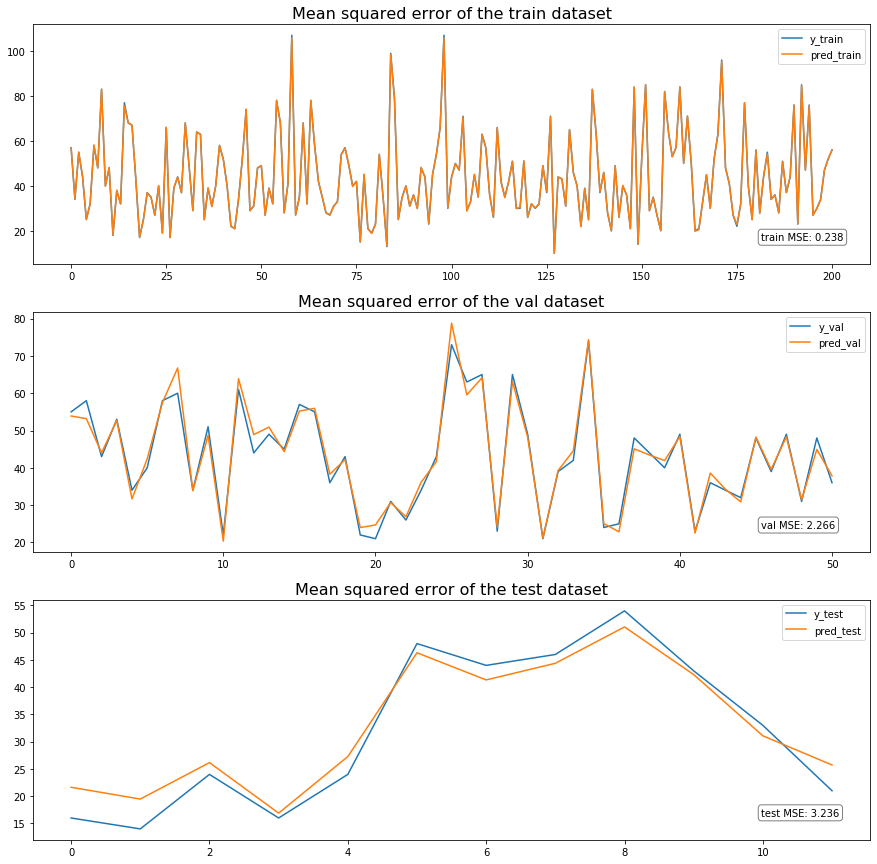

In [14]:
prediction_pipeline(cb, X_train, y_train, X_val, y_val, X_test, y_test)